## Model that only uses news sentiment scores and brent oil futures as primary data

### FinBERT sentiment scores with sentence-vector

In [1]:
import numpy as np
import pandas as pd

from math import sqrt
from matplotlib import pyplot
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
### Postive, Negative and Neutral sentiment (probability scores)
news = pd.read_excel("Data\FinBert_Sentiment_Data\df_bert.xlsx")
news.set_index("date", inplace = True)

In [3]:
## Oil futures data
oil = pd.read_excel("Data\Oil_Data\Brent_Oil_1.xlsx")
oil_raw = pd.read_csv("Data\Oil_Data\oil_raw.csv")

del oil_raw["Open"]
del oil_raw["High"]
del oil_raw["Low"]
del oil_raw["Vol"]
del oil_raw["Price"]

In [4]:
oil_raw['date'] = pd.to_datetime(oil_raw.date)
oil_raw['date'].dt.strftime('%d/%m/%Y')

oil['date'] = pd.to_datetime(oil.date)
oil['date'].dt.strftime('%d/%m/%Y')

oil_raw.set_index("date", inplace = True)
oil.set_index("date", inplace = True)

In [5]:
df1 = oil_raw.merge(news, left_index = True, right_index = True, how ="left").dropna()
df = df1.merge(oil, left_index = True, right_index = True, how ="left").dropna()
df = df.sort_index()

In [6]:
## Adding 7-day cumulative sentiment score for all sentiment labels
df["Positive_7_cumulative_score"] = df["Positive"].rolling(7).sum()
df["Negative_7_cumulative_score"] = df["Negative"].rolling(7).sum()
df["Neutral_7_cumulative_score"] = df["Neutral"].rolling(7).sum()

## Adding 2, 3 and 5-day volatility
df["oil_2_day_volatility"] = df["Change %"].rolling(2).std()
df["oil_3_day_volatility"] = df["Change %"].rolling(3).std()
df["oil_5_day_volatility"] = df["Change %"].rolling(5).std()

In [7]:
df = df.dropna()
df.head()

,Change %,Positive,Negative,Neutral,oil,Positive_7_cumulative_score,Negative_7_cumulative_score,Neutral_7_cumulative_score,oil_2_day_volatility,oil_3_day_volatility,oil_5_day_volatility
date,,,,,,,,,,,
2010-02-15,-0.0053,0.168194,0.011458,0.820348,-1,0.907599,1.741872,4.350529,0.002263,0.006381,0.013331
2010-02-16,0.0437,0.063710,0.111507,0.824784,1,0.958199,0.899196,5.142606,0.034648,0.027413,0.019644
2010-02-17,0.0078,0.070926,0.087685,0.841389,1,0.910931,0.957950,5.131120,0.025385,0.025369,0.019556
2010-02-19,0.0053,0.047434,0.219664,0.732902,1,0.837609,0.977032,5.185359,0.001768,0.021485,0.019641
2010-02-22,0.0054,0.180921,0.091316,0.727764,1,0.937270,1.039157,5.023574,0.000071,0.001415,0.018764


In [8]:
## Shifting predictors by 1, to get predictors at (t-1)
x = df.drop(columns = ["oil"])
x = x.shift(1)
x = x.dropna()  # Removing the NA column

In [9]:
x.head()

,Change %,Positive,Negative,Neutral,Positive_7_cumulative_score,Negative_7_cumulative_score,Neutral_7_cumulative_score,oil_2_day_volatility,oil_3_day_volatility,oil_5_day_volatility
date,,,,,,,,,,
2010-02-16,-0.0053,0.168194,0.011458,0.820348,0.907599,1.741872,4.350529,0.002263,0.006381,0.013331
2010-02-17,0.0437,0.063710,0.111507,0.824784,0.958199,0.899196,5.142606,0.034648,0.027413,0.019644
2010-02-19,0.0078,0.070926,0.087685,0.841389,0.910931,0.957950,5.131120,0.025385,0.025369,0.019556
2010-02-22,0.0053,0.047434,0.219664,0.732902,0.837609,0.977032,5.185359,0.001768,0.021485,0.019641
2010-02-23,0.0054,0.180921,0.091316,0.727764,0.937270,1.039157,5.023574,0.000071,0.001415,0.018764


In [10]:
y = df.drop(columns=["Change %", "Positive", "Negative", "Neutral"])
y = y.iloc[1:]  # Removing the NA column
y = y["oil"]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 0, shuffle=False)

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(x_train)
X_test = scaler.fit_transform(x_test)

In [16]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [17]:
from keras import backend as K

def recall_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, y_pred):
    precision = precision_m(y_test, y_pred)
    recall = recall_m(y_test, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
# designing LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

opt = SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss='hinge', optimizer=opt, metrics=['acc',f1_m,precision_m, recall_m])
# fit network
history = model.fit(X_train, y_train, validation_split=0.10, epochs=10)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/10
77/77 [==============================] - 2s 9ms/step - loss: 0.9992 - acc: 0.0000e+00 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.9923 - val_acc: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
77/77 [==============================] - 0s 3ms/step - loss: 0.9965 - acc: 0.0700 - f1_m: 0.1112 - precision_m: 0.1210 - recall_m: 0.1505 - val_loss: 0.9840 - val_acc: 0.5146 - val_f1_m: 0.6751 - val_precision_m: 0.5166 - val_recall_m: 1.0000
Epoch 3/10
77/77 [==============================] - 0s 3ms/step - loss: 0.9934 - acc: 0.4404 - f1_m: 0.6293 - precision_m: 0.5100 - recall_m: 0.8728 - val_loss: 0.9821 - val_acc: 0.5146 - val_f1_m: 0.6751 - val_precision_m: 0.5166 - val_recall_m: 1.0000
Epoch 4/10
77/77 [==============================] - 0s 3ms/step - loss: 0.9909 - acc: 0.5071 - f1_m: 0.6686 - precision_m: 0.5073 - recall_m: 1.0000 - val_loss: 0.9784 - val_acc: 0.5146 - val_f1_m: 0.6751 -

In [21]:
print("Accuracy: %.2f%%" % (scores[1]*100))
print("F1: %.2f%%" % (f1_score*100))

Accuracy: 59.42%
F1: 72.95%


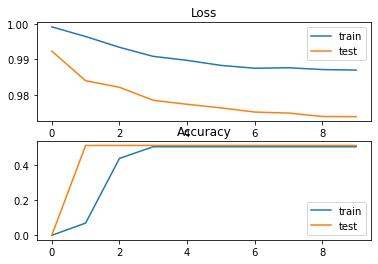

In [22]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()